<a href="https://colab.research.google.com/github/Jeong-ki-hun/Section2_Project/blob/main/%08AI_11_%EC%A0%95%EA%B8%B0%ED%9B%88(Section2_Project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [406]:
!pip install category_encoders
!pip install shap
!pip install pandas_profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 라이브러리 호출

In [490]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rc('font', family='NanumBarunGothic') 
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix
import sklearn
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder, OneHotEncoder
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import shap
from sklearn.linear_model import ElasticNetCV

In [391]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1) 데이터 선정 이유 및 문제 정의

문제 정의 및 선정이유

중고차시장은 점점 커지며 대기업들까지도 진출하고있다.

하지만 소비자들은 중고차 시세에 대해 잘 알지못하는 편이다.

만약 중고차 시세 대해 알수 있다면 합리적인 가격으로 구매가능하며 보다 불편함없이 내가원하는 중고차를 구매할 수 있기 때문에 이데이터셋을 선택하였습니다.


## 데이터는 캐글의 영국 중고차데이터세트(경쟁형식)을 활용하였습니다.

컬럼설명


brand : 브랜드

model : 자동차 모델

year : 년식


transmission : 변속기


mileage : 주행거리


fuelType : 연료종류


tax : 세금


mpg : 연비


engineSize : 엔진사이즈


price:가격



출처 : https://www.kaggle.com/datasets/kukuroo3/used-car-price-dataset-competition-format

In [471]:
x_te = pd.read_csv('/content/drive/MyDrive/archive (14)/X_test.csv',encoding='cp949')
x_tr = pd.read_csv('/content/drive/MyDrive/archive (14)/X_train.csv',encoding='cp949')
y_tr = pd.read_csv('/content/drive/MyDrive/archive (14)/y_train.csv',encoding='cp949')
y_te = pd.read_csv('/content/drive/MyDrive/archive (14)/y_test.csv',encoding='cp949')
tr = pd.merge(x_tr,y_tr,how='inner',on='carID')
ts = pd.merge(x_te,y_te,how='inner',on='carID')
df = pd.concat([tr,ts]).reset_index(drop=True)

In [472]:
df

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,13207,hyundi,Santa Fe,2019,Semi-Auto,4223,Diesel,145.0,39.8,2.2,31995
1,17314,vauxhall,GTC,2015,Manual,47870,Diesel,125.0,60.1,2.0,7700
2,12342,audi,RS4,2019,Automatic,5151,Petrol,145.0,29.1,2.9,58990
3,13426,vw,Scirocco,2016,Automatic,20423,Diesel,30.0,57.6,2.0,12999
4,16004,skoda,Scala,2020,Semi-Auto,3569,Petrol,145.0,47.1,1.0,16990
...,...,...,...,...,...,...,...,...,...,...,...
7627,19618,audi,A7,2015,Semi-Auto,21100,Petrol,325.0,29.7,4.0,28990
7628,19620,merc,CLS Class,2015,Automatic,60972,Diesel,160.0,52.3,3.0,17450
7629,19626,ford,Puma,2020,Manual,4111,Petrol,145.0,50.4,1.0,21995
7630,19630,merc,CLA Class,2016,Automatic,25726,Petrol,200.0,41.5,2.0,18700


데이터를 평가지표, 베이스라인모델 선택

회귀문제이기 때문에 타켓의 평균값을 사용하여 처리

# 데이터 전처리 및 EDA

In [473]:
df.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,13207,hyundi,Santa Fe,2019,Semi-Auto,4223,Diesel,145.0,39.8,2.2,31995
1,17314,vauxhall,GTC,2015,Manual,47870,Diesel,125.0,60.1,2.0,7700
2,12342,audi,RS4,2019,Automatic,5151,Petrol,145.0,29.1,2.9,58990
3,13426,vw,Scirocco,2016,Automatic,20423,Diesel,30.0,57.6,2.0,12999
4,16004,skoda,Scala,2020,Semi-Auto,3569,Petrol,145.0,47.1,1.0,16990


우선 필요없는 컬럼인 carid칼럼을 삭제시켜줍니다.

In [474]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7632 entries, 0 to 7631
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carID         7632 non-null   int64  
 1   brand         7632 non-null   object 
 2   model         7632 non-null   object 
 3   year          7632 non-null   int64  
 4   transmission  7632 non-null   object 
 5   mileage       7632 non-null   int64  
 6   fuelType      7632 non-null   object 
 7   tax           7632 non-null   float64
 8   mpg           7632 non-null   float64
 9   engineSize    7632 non-null   float64
 10  price         7632 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 656.0+ KB


In [475]:
df.isnull().sum()

carID           0
brand           0
model           0
year            0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
price           0
dtype: int64

In [476]:
df.drop(columns=['carID'],axis=1,inplace=True)

In [477]:
df['brand'].unique()

array(['hyundi', 'vauxhall', 'audi', 'vw', 'skoda', 'merc', 'toyota',
       'bmw', 'ford'], dtype=object)

In [478]:
df['model'].unique()

array([' Santa Fe', ' GTC', ' RS4', ' Scirocco', ' Scala', ' V Class',
       ' Prius', ' M4', ' Camry', ' KA', ' Vivaro', ' CLS Class',
       ' Caravelle', ' Arteon', ' Shuttle', ' I40', ' IX20', ' 6 Series',
       ' GL Class', ' S Class', ' S3', ' Yeti', ' Galaxy', ' Puma',
       ' Edge', ' A8', ' SLK', ' Kamiq', ' RS6', ' CLA Class',
       ' Land Cruiser', ' M Class', ' Q8', ' i3', ' Verso', ' Mustang',
       ' IX35', ' Amarok', ' Avensis', ' Grand Tourneo Connect',
       ' Antara', ' Tourneo Connect', ' Beetle', ' X4', ' CC', ' GT86',
       ' X-CLASS', ' I800', ' i8', ' Caddy Maxi Life', ' Combo Life',
       ' Rapid', ' SQ7', ' Grand C-MAX', ' Tourneo Custom', ' California',
       ' Agila', ' A7', ' Zafira Tourer', ' G Class', ' Tiguan Allspace',
       ' X6', ' M2', ' X7', ' 7 Series', ' Z4', ' RS5', ' Hilux',
       ' GLS Class', ' GLB Class', ' M5', ' RS3', ' Caddy Life', ' SQ5',
       ' Supra', ' 8 Series', ' Fusion', ' M6', ' M3', ' Jetta', ' S4',
       ' R8', ' PRO

In [488]:
df

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,hyundi,Santa Fe,2019,Semi-Auto,4223,Diesel,145.0,39.8,2.2,31995
1,vauxhall,GTC,2015,Manual,47870,Diesel,125.0,60.1,2.0,7700
2,audi,RS4,2019,Automatic,5151,Petrol,145.0,29.1,2.9,58990
3,vw,Scirocco,2016,Automatic,20423,Diesel,30.0,57.6,2.0,12999
4,skoda,Scala,2020,Semi-Auto,3569,Petrol,145.0,47.1,1.0,16990
...,...,...,...,...,...,...,...,...,...,...
7627,audi,A7,2015,Semi-Auto,21100,Petrol,325.0,29.7,4.0,28990
7628,merc,CLS Class,2015,Automatic,60972,Diesel,160.0,52.3,3.0,17450
7629,ford,Puma,2020,Manual,4111,Petrol,145.0,50.4,1.0,21995
7630,merc,CLA Class,2016,Automatic,25726,Petrol,200.0,41.5,2.0,18700


### 데이터 시각화

제조사별 평균단가

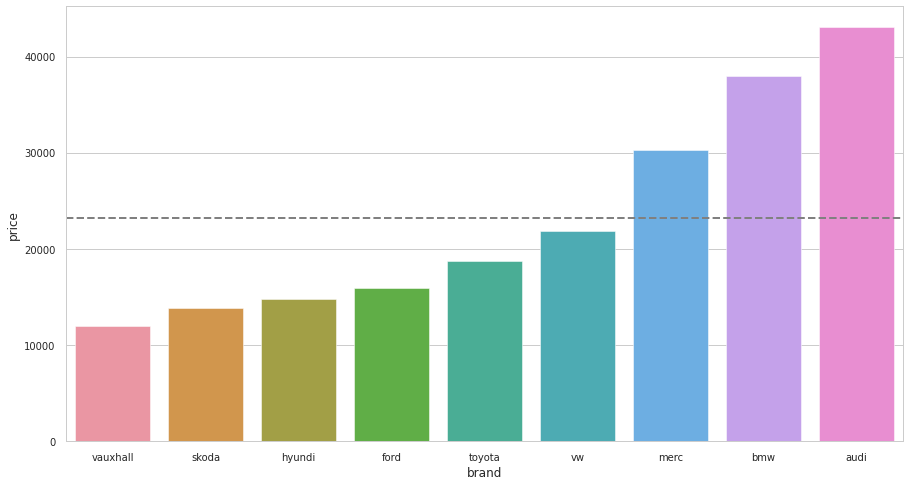

In [509]:
brand = df.groupby('brand')['price'].mean().to_frame().sort_values(by='price')
fig = plt.figure(figsize=(15, 8))
sns.barplot(x=brand.index,y='price',data=brand)
plt.axhline(y = brand['price'].mean(), color = 'gray', linestyle = '--', linewidth = 2)

연식별 평균단가

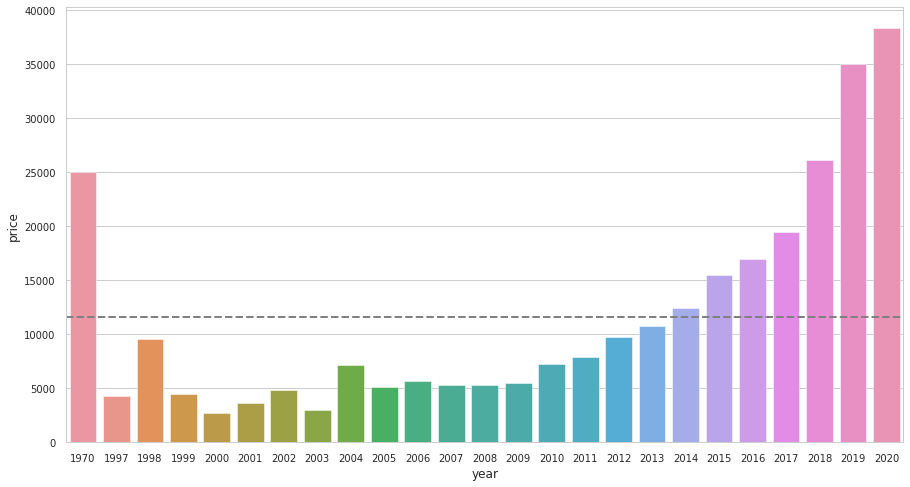

In [515]:
year = df.groupby('year')['price'].mean().to_frame().sort_values(by='price')
fig = plt.figure(figsize=(15, 8))
sns.barplot(x=year.index,y='price',data=year)
plt.axhline(y = year['price'].mean(), color = 'gray', linestyle = '--', linewidth = 2)

In [517]:
df.loc[df['year']==1970]

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
6782,merc,M Class,1970,Automatic,14000,Diesel,305.0,39.2,0.0,24999


In [518]:
df.loc[df['year']==1998]

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
3014,merc,S Class,1998,Automatic,43534,Petrol,265.0,23.3,6.0,19990
4578,merc,SLK,1998,Automatic,113557,Petrol,265.0,32.1,2.3,1990
6154,toyota,Land Cruiser,1998,Manual,100000,Diesel,265.0,23.9,4.2,19990
6984,merc,SLK,1998,Automatic,99300,Petrol,265.0,32.1,2.3,1990
7045,bmw,Z3,1998,Manual,56500,Petrol,270.0,35.3,1.9,3950


변속유형별 평균단가

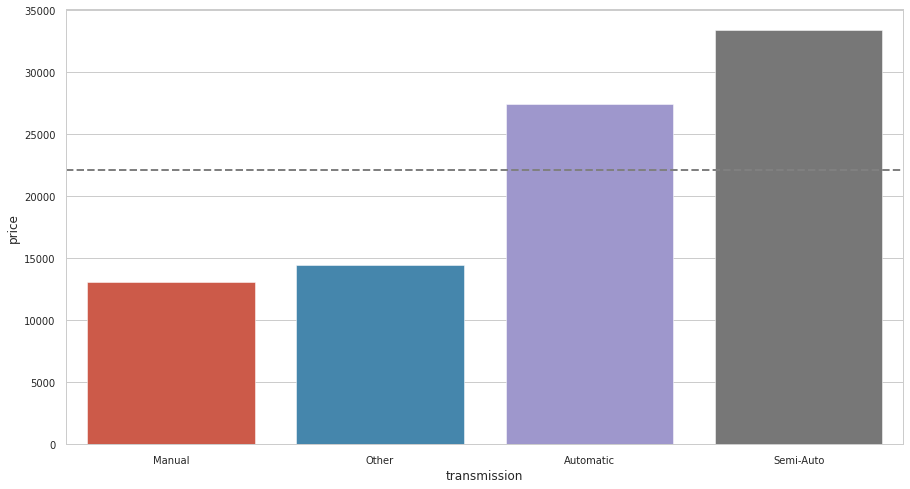

In [520]:
tran = df.groupby('transmission')['price'].mean().to_frame().sort_values(by='price')
fig = plt.figure(figsize=(15, 8))
sns.barplot(x=tran.index,y='price',data=tran)
plt.axhline(y = tran['price'].mean(), color = 'gray', linestyle = '--', linewidth = 2)

연료 유형별 평균단가

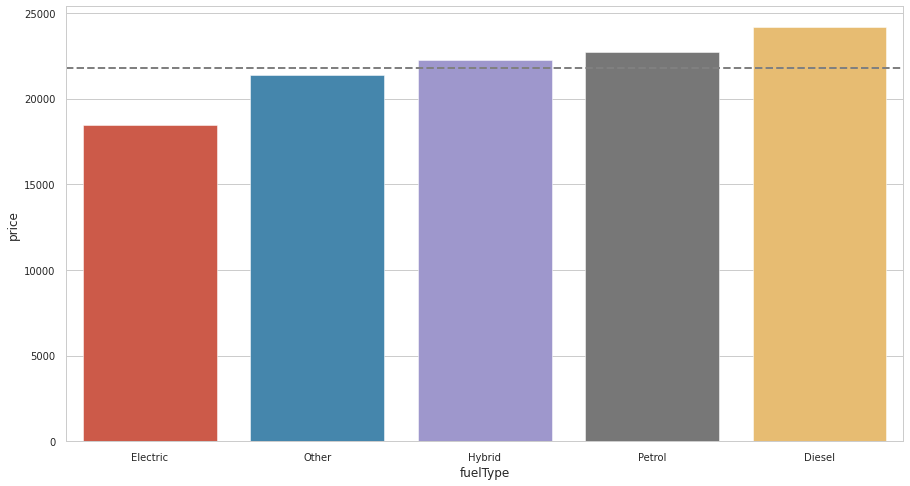

In [521]:
fuel = df.groupby('fuelType')['price'].mean().to_frame().sort_values(by='price')
fig = plt.figure(figsize=(15, 8))
sns.barplot(x=fuel.index,y='price',data=fuel)
plt.axhline(y = fuel['price'].mean(), color = 'gray', linestyle = '--', linewidth = 2)

수치형 컬럼에대한 상관관계분석 히트맵

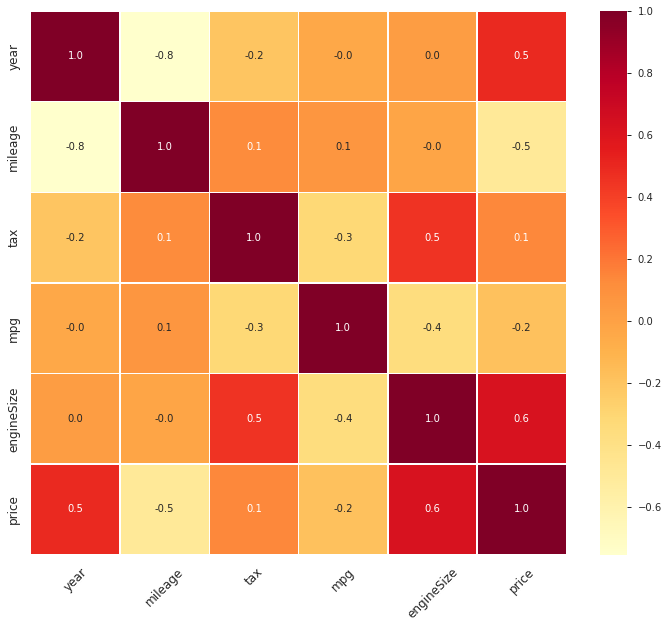

In [533]:
fig, ax = plt.subplots(figsize=(12,10))

sns.heatmap(df.corr(), # 위에서 전처리한 데이터프레임
            annot = True, # 숫자 표시 여부
            ax = ax, # 히트맵을 그릴 격자
            linewidths = 0.4, # 선의 굵기
            linecolor = 'white', # 선의 색깔
            fmt = '.1f', # 소수점 포맷팅 형태
            cmap = 'YlOrRd') # colormap 형태



plt.xticks(rotation=45, size = 12)
plt.yticks(size=12) 
plt.show()

## 4) 머신러닝 방식 적용 및 교차검증

In [547]:
target = df['price']
features = df.drop(columns='price')

In [567]:
x_train,x_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=42)

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(6105, 9) (1527, 9) (6105,) (1527,)


In [568]:
orderinal=OrdinalEncoder()
x_train_encoded=orderinal.fit_transform(x_train)
x_test_encoded=orderinal.fit_transform(x_test)

기준모델 생성

In [573]:
base_model = df['price'].mean()

In [595]:
price=pd.DataFrame(df['price'])

In [590]:
price['base_model']

0       23579.922825
1       23579.922825
2       23579.922825
3       23579.922825
4       23579.922825
            ...     
7627    23579.922825
7628    23579.922825
7629    23579.922825
7630    23579.922825
7631    23579.922825
Name: base_model, Length: 7632, dtype: float64

In [598]:
y = df['price']
price = pd.DataFrame(y)
mean = y.mean()
bs_pred = pd.DataFrame([mean] * len(y), columns = ['bs_pred'])

bs = pd.concat([price, bs_pred], axis = 1)

bs

,price,bs_pred
0,31995,23579.922825
1,7700,23579.922825
2,58990,23579.922825
3,12999,23579.922825
4,16990,23579.922825
...,...,...
7627,28990,23579.922825
7628,17450,23579.922825
7629,21995,23579.922825
7630,18700,23579.922825


In [594]:
base_model=pd.DataFrame(price['base_model'])

In [600]:
print('기준 모델의 R2 Score', r2_score(price, bs_pred))

기준 모델의 R2 Score 0.0


In [583]:
price

,price,base_model
0,31995,23579.922825
1,7700,23579.922825
2,58990,23579.922825
3,12999,23579.922825
4,16990,23579.922825
...,...,...
7627,28990,23579.922825
7628,17450,23579.922825
7629,21995,23579.922825
7630,18700,23579.922825


In [541]:
errors

0       -8415.077175
1       15879.922825
2      -35410.077175
3       10580.922825
4        6589.922825
            ...     
7627    -5410.077175
7628     6129.922825
7629     1584.922825
7630     4879.922825
7631    20580.922825
Name: price, Length: 7632, dtype: float64

In [545]:
mean_absolute_error = errors.abs().mean()

In [571]:
print(r2_score(df['price'].mean(),df['price']))

TypeError: ignored